# find a golden cuts-point using symplex algorithm + manual scanning

In [1]:
import sys; sys.path.insert(0, '../../AnaTreesPackage/notebooks')
from notebooks_tools import * 
from ccqe_notebook_tools import *
from matplotlib import ticker
import scipy.optimize as optimize
%matplotlib inline

# load the data

In [2]:
extBNB2tracks = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_extBNB.csv')
print len(extBNB2tracks),'extBNB 2-tracks clusters'
OpenCosmic2tracks = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_openCOSMIC_MC.csv')
print len(OpenCosmic2tracks),'OpenCosmic 2-tracks clusters'

66546 extBNB 2-tracks clusters
17560 OpenCosmic 2-tracks clusters


In [3]:
MCevents = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_MC_BNB.csv')
# MCevents = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_CC1pTopology_MCC7_MC_BNB_InTimeCOSMIC_MC.csv')
print len(MCevents),'2-tracks clusters from MC-BNB events'

MCeventsTrueCC1p = MCevents[MCevents.GENIECC1p==1]
print len(MCeventsTrueCC1p), 'are true (GENIE) cc1p'

MCeventsTrueCC1pAndTagged = MCeventsTrueCC1p[MCeventsTrueCC1p.l_large_pida < MCeventsTrueCC1p.l_small_pida]
print len(MCeventsTrueCC1pAndTagged), 'are true (GENIE) cc1p in which l(large-PID_A)<l(small-PID_A)'

MCeventsNonTrueCC1p = MCevents[MCevents.GENIECC1p!=1]
print len(MCeventsNonTrueCC1p), 'are non true (GENIE) cc1p'

# MCeventsNonTrueCC1p1mu1p = MCevents[(MCevents.Is1mu1p==True) & (MCevents.GENIECC1p==False)]
# print len(MCeventsNonTrueCC1p1mu1p), 'are 2-tracks clusters of 1µ1p'

MCeventsNonTrueCC1p1mu1p = MCeventsNonTrueCC1p[(MCeventsNonTrueCC1p.pdg_long*MCeventsNonTrueCC1p.pdg_short == 28756)]
print len(MCeventsNonTrueCC1p1mu1p), 'are 2-tracks clusters of 1µ1p'


# MCeventsNon1mu1p = MCevents[MCevents.Is1mu1p==False]
# print len(MCeventsNon1mu1p), 'are 2-tracks not 1µ1p'

MCeventsNon1mu1p = MCeventsNonTrueCC1p[(MCeventsNonTrueCC1p.pdg_long*MCeventsNonTrueCC1p.pdg_short != 28756)]
print len(MCeventsNon1mu1p), 'are 2-tracks not 1µ1p'

print len(MCeventsNonTrueCC1p1mu1p) +  len(MCeventsNon1mu1p), ' 1µ1p and not 1µ1p together'
samples = [MCeventsTrueCC1p , MCeventsTrueCC1pAndTagged , MCeventsNonTrueCC1p1mu1p, MCeventsNon1mu1p , extBNB2tracks, OpenCosmic2tracks]
labels = ['MC-BNB true(GENIE) CC1p' , 'true CC1p, l(large-PIDA)<l(small-PIDA)' , '1$\\mu$1p non CC1p' , 'non 1$\\mu$1p' , 'ext-BNB 2-tracks clusters', 'open-cosmic MC']

82286 2-tracks clusters from MC-BNB events
7245 are true (GENIE) cc1p
5930 are true (GENIE) cc1p in which l(large-PID_A)<l(small-PID_A)
75041 are non true (GENIE) cc1p
11676 are 2-tracks clusters of 1µ1p
63365 are 2-tracks not 1µ1p
75041  1µ1p and not 1µ1p together


In [4]:
def sample_in_selected_cut( data=None, label='' ,do_print=False
                           ,FV_y_max = 110 # [cm]
                           ,delta_Delta_phi = 180 # around 180 [deg.]
                           ,theta_pq_max = 180 # [deg.]
                           ,delta_p_over_q = 2
                           ,delta_cfdistance = 200 # closest flash distance [cm]
#                            ,delta_2_tracks_angle = 100 # angle between the two tracks
                           ,minimal_PIDA_large_pida=0
                           ,maximal_PIDA_small_pida=200
                           ,minimal_length_long = 0 # [cm]
                           ,maximal_length_short = 1000 # [cm]
                           ,max_Pt=100 # [GeV/c]
                           ,Xb_min=0.2
                           ,Xb_Pt_correlation_width=0.5
                           ,W2_max = 2
                           ,dqdx_around_vertex_non_tracks_associated_max=20000
                           ,large_pidA_small_pidA_ratio_min=0
                          ):
    average_p_over_q = np.average(MCeventsTrueCC1p['reco_CC1p_p_over_q'])
    average_delta_phi = np.average(MCeventsTrueCC1p['delta_phi'])
    
    reduced = data[                     
        # define a new FV cut for cosmic supression
        (np.fabs(data['starty_short']) < FV_y_max)        
        & (np.fabs(data['starty_long']) < FV_y_max)
        & (np.fabs(data['endy_short']) < FV_y_max)        
        & (np.fabs(data['endy_long']) < FV_y_max)        

        # match the closest flash
        & (np.fabs(data['cfdistance_long']) < delta_cfdistance)
        & (np.fabs(data['cfdistance_short']) < delta_cfdistance)        

        # cut on delta \phi for QE topology - QE physics
        & (np.fabs(data['delta_phi']-average_delta_phi) < delta_Delta_phi)        
        & (data['reco_CC1p_Xb'] > Xb_min)        
        & (data['reco_CC1p_Pt'] < max_Pt)
        & (data['reco_CC1p_omega'] > 0.0)        
        & (data['reco_CC1p_Ev'] > 0.0)
        # hypothesis of CC1p
        & (data['reco_CC1p_Pmu_x'] + data['reco_CC1p_Pp_x'] < max_Pt)
        & (data['reco_CC1p_Pmu_y'] + data['reco_CC1p_Pp_y'] < max_Pt)
        & ( data['reco_CC1p_W2'] < W2_max )
        & ( data['reco_CC1p_n_miss'] < 1. )


        
        # cut on reconstructed \theta(p,q) - this comes only from physics - QE physics
        & ( data['reco_CC1p_theta_pq'] < theta_pq_max )
        # cut on reconstructed p/q - this comes only from physics - QE physics
        & ( np.fabs(data['reco_CC1p_p_over_q']-average_p_over_q) < delta_p_over_q )
        # angle between the two tracks
        #         & ( np.fabs(180./np.pi*data['2_tracks_angle']-90) < delta_2_tracks_angle )        

        # pid-A of the higher ionizing track
        & ( data['PIDA_large_pida'] > minimal_PIDA_large_pida )        
        # pid-A of the less ionizing track
        & ( data['PIDA_small_pida'] < maximal_PIDA_small_pida )
        & ( data['PIDA_large_pida']/data['PIDA_small_pida'] > large_pidA_small_pidA_ratio_min )

        # length of the long track        
        & ( data['l_long'] > minimal_length_long )        
        # length of the short track        
        & ( data['l_short'] < maximal_length_short )        
        
        # new cuts
        # test - would it help if we demand that the length of the 'muon' is longer than the length of the 'proton'
        & ( data['l_large_pida'] < data['l_small_pida'] )
        & ( np.fabs(data['reco_CC1p_Xb'] - (0.75-5*data['reco_CC1p_Pt'])) < Xb_Pt_correlation_width )
        & ( data['dqdx_around_vertex_non_tracks_associated'] <= dqdx_around_vertex_non_tracks_associated_max )
        & (data['reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff'] < 2)
    ]    
    frac = 100.0 * float(len(reduced)) / float(len(data))
    frac_err = frac * np.sqrt( 1./len(reduced) + 1./len(data) ) if len(reduced)>0 else frac / np.sqrt(len(data))
    if do_print: print label,"retained %.2f +/- %.2f"%(frac,frac_err)+ "% in this cut " + "(%d pairs)"%len(reduced)
    return reduced , frac , frac_err

In [5]:
def frac_in_cut(sample=None,x=None):
    [FV_y_max ,
     delta_Delta_phi ,
     theta_pq_max ,
     delta_p_over_q ,
     delta_cfdistance , 
     minimal_PIDA_large_pida ,
     maximal_PIDA_small_pida ,
     large_pidA_small_pidA_ratio_min,
     minimal_length_long ,
     maximal_length_short , 
     max_Pt,
     Xb_min ,
     Xb_Pt_correlation_width ,
     W2_max ,
     dqdx_around_vertex_non_tracks_associated_max ] = x
    
    r,frac,f_err = sample_in_selected_cut( data=sample, label='' ,do_print=False
                                           ,FV_y_max=FV_y_max # [cm]
                                           ,delta_Delta_phi = delta_Delta_phi # around 180 [deg.]
                                           ,theta_pq_max = theta_pq_max # [deg.]
                                           ,delta_p_over_q = delta_p_over_q 
                                           ,delta_cfdistance = delta_cfdistance # closest flash distance [cm]
                                           ,minimal_PIDA_large_pida=minimal_PIDA_large_pida
                                           ,maximal_PIDA_small_pida=maximal_PIDA_small_pida
                                          ,large_pidA_small_pidA_ratio_min = large_pidA_small_pidA_ratio_min
                                           ,minimal_length_long = minimal_length_long # [cm]                                            
                                          ,maximal_length_short = maximal_length_short # [cm]                                          
                                          ,max_Pt=max_Pt
                                          ,Xb_min=Xb_min
                                          ,Xb_Pt_correlation_width=Xb_Pt_correlation_width
                                          ,W2_max=W2_max 
                                          ,dqdx_around_vertex_non_tracks_associated_max=dqdx_around_vertex_non_tracks_associated_max
                                            #                                            ,delta_2_tracks_angle = delta_2_tracks_angle
                                         )
    return frac

In [6]:
def reduced_in_cut(sample=None,x=None):
    [FV_y_max ,
     delta_Delta_phi ,
     theta_pq_max ,
     delta_p_over_q ,
     delta_cfdistance , 
     minimal_PIDA_large_pida ,
     maximal_PIDA_small_pida ,
     large_pidA_small_pidA_ratio_min,
     minimal_length_long ,
     maximal_length_short , 
     max_Pt,
     Xb_min ,
     Xb_Pt_correlation_width ,
     W2_max ,
     dqdx_around_vertex_non_tracks_associated_max ] = x
    
    r,frac,f_err = sample_in_selected_cut( data=sample, label='' ,do_print=False
                                           ,FV_y_max=FV_y_max # [cm]
                                           ,delta_Delta_phi = delta_Delta_phi # around 180 [deg.]
                                           ,theta_pq_max = theta_pq_max # [deg.]
                                           ,delta_p_over_q = delta_p_over_q 
                                           ,delta_cfdistance = delta_cfdistance # closest flash distance [cm]
                                           ,minimal_PIDA_large_pida=minimal_PIDA_large_pida
                                           ,maximal_PIDA_small_pida=maximal_PIDA_small_pida
                                          ,large_pidA_small_pidA_ratio_min = large_pidA_small_pidA_ratio_min
                                           ,minimal_length_long = minimal_length_long # [cm]                                            
                                          ,maximal_length_short = maximal_length_short # [cm]                                          
                                          ,max_Pt=max_Pt
                                          ,Xb_min=Xb_min
                                          ,Xb_Pt_correlation_width=Xb_Pt_correlation_width
                                          ,W2_max=W2_max 
                                          ,dqdx_around_vertex_non_tracks_associated_max=dqdx_around_vertex_non_tracks_associated_max
                                            #                                            ,delta_2_tracks_angle = delta_2_tracks_angle
                                         )
    return r

In [7]:
def print_final_frac_in_samples(values):
    number = []
    for i,sample,label in zip(range(len(samples)),samples,labels):
        f = frac_in_cut(sample=sample,x=values)
        number.append(0.01*f*len(sample))
        print label , ': %.2f'%f + '%' + '(%d)'%number[i]
    for i,sample,label in zip(range(2),samples,labels):
        print label , 'purity: %.2f'%(float(number[i])/(number[i]+number[2]+number[3]+10*number[4]+10*number[5]))

# using symplex

In [178]:
def max_eff_in_selected_cuts(x):
    frac,number = [],[]
    for i,sample,label in zip(range(len(samples)),samples,labels):
        f = frac_in_cut(sample=sample,x=x)
        frac.append(f)
        number.append(0.01*f*len(sample))
    efficiency = frac[0]        
    purity = number[0]/(number[0]+number[2]+number[3]+number[4]+number[5]) if sum(number)>0 else sum(number)
    result = -purity #  10*(frac[2]+frac[3])-frac[0]
    if frac[0]>2 and frac[2]<0.1 and frac[3]<0.1:
        print x
        print frac
        print 'purity:',purity
#         print 'result:',result        
        print        
    return result

#     purity = frac[0]/(frac[0] + 10*frac[2] + frac[3] + frac[4]) if (frac[0] + frac[2] + frac[3] + frac[4])>0 and frac[0]>10 else frac[2] + frac[3] + frac[4]
#     return 5*(frac[2]+frac[3]+frac[4])-frac[0]
#     return -purity*efficiency
#     return -(frac[0])*np.abs((1-frac[1]*100000)*(1-frac[2]*100000)*(1-frac[3]*100000))

In [180]:
# y(max), 𝚫ɸ, 𝜃(p,q), p/q, cfdis, large-pida(min), small-pida(max), l_long(min), l_short(max), Pt(max), Xb(min), Xb-Pt(width)
init = [99.087, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
steps = init # [2 , 5. , 5 , 0.2 , 30 , 11 , 11 , 1 , 10 , 30 , 0.15 , 0.01 ,0.2 ,0.5 , 500 ] 
s = Simplex(max_eff_in_selected_cuts, init, steps) 
v, err, iter = s.minimize(epsilon = 0.1, maxiters = 100, monitor = 0)
del(s)
print 'finished after ', iter,'iterations'
print v
print_final_frac_in_samples(v)

[99.087, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.0833333333333335, 2.5331724969843186, 0.06218905472636816, 0.0050685521680731895, 0.0, 0.0]
purity: 0.875
result: -0.875

[198.174, 10, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.1825396825396823, 2.6537997587454765, 0.06218905472636816, 0.007602828252109785, 0.0030054398461214797, 0.0]
purity: 0.785714285714
result: -0.785714285714

[99.087, 20, 8, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.7777777777777777, 3.3775633293124248, 0.06218905472636816, 0.012671380420182975, 0.0, 0.0]
purity: 0.823529411765
result: -0.823529411765

[99.087, 10, 16, 0.3, 97.63, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 0.79, 1.327, 10245.0]
[2.7777777777777777, 3.3775633293124248, 0.06218905472636816, 0.010137104336146379, 0.0, 0.0]
purity: 0.848484848485
result: -0.848484848485

[99.087, 10, 8, 0.3, 195.26, 18.4, 14.9, 3, 21.3, 117.3, 0.25, 0.01, 

# reduced samples charecteristics

In [8]:
#   y(max) ,
#   𝚫ɸ ,
#   𝜃(p,q) ,
#   p/q ,
#   cfdis , 
#   large-pida(min) ,
#   small-pida(max) ,
#   l-long(min) ,
#   l-short(max) , 
#   Pt(max),
#   Xb(min),
#   Xb-Pt(width)
#   W2-max ,
#   dq/dx around vertex non-tracks-associated (max) 
init = [98.087, 14, 11, 0.5, 97.63, 6.4, 109.9, 1, 21.3, 117.3, 0.25, 0.0, 2.79, 1.527, 20245.0]
reduced, number = [] , []
for sample,label in zip(samples,labels):
    r = reduced_in_cut(sample=sample,x=init)
    reduced.append(r)
    number.append(len(r))
    print label,':',number[-1]
    
print 'purity: %.2f'%(float(number[0])/(number[0]+number[2]+number[3]+number[4]))

MC-BNB true(GENIE) CC1p : 1688
true CC1p, l(large-PIDA)<l(small-PIDA) : 1688
1$\mu$1p non CC1p : 215
non 1$\mu$1p : 78
ext-BNB 2-tracks clusters : 1
open-cosmic MC : 0
purity: 0.85


## good true 1µ1p

In [10]:
goodcc1p = reduced[1]
print 'len(goodcc1p):',len(goodcc1p)
for i,row in goodcc1p[0:10].iterrows():
    print "hits, tracks = get_event_from_rse(  events=events, run=%d , subrun=%d , event=%d )"%(row['run'],row['subrun'],row['event'])
    print "draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[%f],vertex_y=[%f],vertex_z=[%f])"%(row['vertex_x'],row['vertex_y'],row['vertex_z'])
    print 
goodcc1p[['event','pdg','process_primary','distance',
       'truth_startx','startx','truth_starty','starty','truth_startz','startz',
       'closest_genie_distance',
       'closest_genie_x','closest_genie_y','closest_genie_Ev','reco_CC1p_Ev']]

len(goodcc1p): 1688
hits, tracks = get_event_from_rse(  events=events, run=4 , subrun=8805 , event=176092 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[144.507000],vertex_y=[51.018800],vertex_z=[971.405000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=4371 , event=87403 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[222.451000],vertex_y=[37.130400],vertex_z=[576.473000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=698 , event=13954 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[207.654000],vertex_y=[-97.165700],vertex_z=[590.743000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=491 , event=9806 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[124.531000],vertex_y=[-72.751900],vertex_z=[491.605000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=4260 , event=85190 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[191.381000],vertex_y=[2.266730],vertex_z=[678.139000])

h

,event,pdg,process_primary,distance,truth_startx,startx,truth_starty,starty,truth_startz,startz,closest_genie_distance,closest_genie_x,closest_genie_y,closest_genie_Ev,reco_CC1p_Ev
151,176092,"[13, 2212]","[1, 1]",0.260604,"[143.95570373535156, 143.95570373535156]","[144.4646759033203, 144.5495147705078]","[51.071563720703125, 51.071563720703125]","[51.045921325683594, 50.99164581298828]","[971.397705078125, 971.397705078125]","[971.2850341796875, 971.525390625]",0.553963,143.9560,51.071600,0.426182,0.512489
244,87403,"[13, 2212]","[1, 1]",0.349532,"[221.80923461914062, 221.80923461914062]","[222.44395446777344, 222.45864868164062]","[37.257694244384766, 37.257694244384766]","[37.2463264465332, 37.01449203491211]","[576.4570922851562, 576.4570922851562]","[576.342529296875, 576.6036987304688]",0.654758,221.8090,37.257700,0.917827,0.917987
396,13954,"[13, 2212]","[1, 1]",0.269529,"[207.4666290283203, 207.4666290283203]","[207.53369140625, 207.77345275878906]","[-97.1597671508789, -97.1597671508789]","[-97.11268615722656, -97.2187728881836]","[591.0120239257812, 591.0120239257812]","[590.7113037109375, 590.7738037109375]",0.328021,207.4670,-97.159800,0.934018,0.686693
410,9806,"[13, 2212]","[1, 1]",1.737300,"[124.14862823486328, 124.14862823486328]","[124.53501892089844, 124.52682495117188]","[-73.62616729736328, -73.62616729736328]","[-72.44196319580078, -73.06192779541016]","[493.0491943359375, 493.0491943359375]","[492.41595458984375, 490.7930603027344]",1.731340,124.1490,-73.626200,0.601813,0.661626
659,85190,"[13, 2212]","[1, 1]",1.142720,"[190.67025756835938, 190.67025756835938]","[191.63038635253906, 191.13197326660156]","[2.906050682067871, 2.906050682067871]","[1.771410346031189, 2.7620413303375244]","[677.8675537109375, 677.8675537109375]","[678.2767944335938, 678.0010375976562]",0.993873,190.6700,2.906050,0.535443,0.545826
662,85195,"[13, 2212]","[1, 1]",1.254530,"[186.30551147460938, 186.30551147460938]","[187.37278747558594, 186.83526611328125]","[-61.90664291381836, -61.90664291381836]","[-62.09080505371094, -61.79807662963867]","[535.9885864257812, 535.9885864257812]","[534.9600219726562, 536.0551147460938]",0.932970,186.3060,-61.906600,0.779019,0.841501
817,43562,"[13, 2212]","[1, 1]",1.393830,"[87.69994354248047, 87.69994354248047]","[88.48079681396484, 88.11726379394531]","[-18.27185821533203, -18.27185821533203]","[-19.113271713256836, -18.22222328186035]","[141.39524841308594, 141.39524841308594]","[142.3206787109375, 141.31239318847656]",0.832536,87.6999,-18.271900,0.610211,0.686522
952,148872,"[13, 2212]","[1, 1]",0.461123,"[137.3365478515625, 137.3365478515625]","[137.5702362060547, 137.9349365234375]","[-65.87449645996094, -65.87449645996094]","[-65.83297729492188, -65.99768829345703]","[885.2860107421875, 885.2860107421875]","[884.9429931640625, 885.172119140625]",0.476390,137.3370,-65.874500,0.695754,0.852744
988,7878,"[13, 2212]","[1, 1]",2.097070,"[81.20765686035156, 81.20765686035156]","[149.56167602539062, 82.10517883300781]","[-8.750263214111328, -8.750263214111328]","[-93.96650695800781, -9.10194206237793]","[271.7112731933594, 271.7112731933594]","[254.68536376953125, 270.8094482421875]",0.514582,81.2077,-8.750260,0.594876,0.493974
1030,24651,"[13, 2212]","[1, 1]",0.401799,"[136.51925659179688, 136.51925659179688]","[137.25369262695312, 137.35462951660156]","[-31.713708877563477, -31.713708877563477]","[-31.761816024780273, -31.817214965820312]","[682.4340209960938, 682.4340209960938]","[682.2606811523438, 682.6456298828125]",0.788789,136.5190,-31.713700,0.894267,0.880788


## badly reconstructed 1µ1p

In [64]:
BadReconstructed = reduced[2][(reduced[2].closest_genie_Np==1) & (reduced[2].closest_genie_Nn==0) &(reduced[2].closest_genie_Npi==0) & (reduced[2].closest_genie_Nel==0)]
print 'len(BadReconstructed):',len(BadReconstructed)
for i,row in BadReconstructed.iterrows():
    print "hits, tracks = get_event_from_rse(  events=events, run=%d , subrun=%d , event=%d )"%(row['run'],row['subrun'],row['event'])
    print "draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[%f],vertex_y=[%f],vertex_z=[%f])"%(row['vertex_x'],row['vertex_y'],row['vertex_z'])
    print 
BadReconstructed[['event','pdg','process_primary','distance',
       'truth_startx','startx','truth_starty','starty','truth_startz','startz',
       'closest_genie_distance',
       'closest_genie_x','closest_genie_y','closest_genie_Ev','reco_CC1p_Ev']]

len(BadReconstructed): 32
hits, tracks = get_event_from_rse(  events=events, run=6 , subrun=9387 , event=187740 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[35.825500],vertex_y=[83.596600],vertex_z=[900.111000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=1972 , event=39421 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[109.581000],vertex_y=[-17.152700],vertex_z=[1000.880000])

hits, tracks = get_event_from_rse(  events=events, run=6 , subrun=4121 , event=82412 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[40.439700],vertex_y=[32.214300],vertex_z=[920.041000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=4298 , event=85944 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[156.612000],vertex_y=[19.013600],vertex_z=[14.419200])

hits, tracks = get_event_from_rse(  events=events, run=1 , subrun=2016 , event=40316 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[87.873100],vertex_y=[24.112400],vertex_z=[437.43400

,event,pdg,process_primary,distance,truth_startx,startx,truth_starty,starty,truth_startz,startz,closest_genie_distance,closest_genie_x,closest_genie_y,closest_genie_Ev,reco_CC1p_Ev
549,187740,"[13, 2212]","[1, 0]",0.538813,"[35.08827209472656, 23.97632598876953]","[35.825469970703125, 35.65011215209961]","[83.78060913085938, 91.22509002685547]","[83.59664916992188, 83.8502197265625]","[899.8809204101562, 915.5449829101562]","[900.1106567382812, 899.6687622070312]",0.793776,35.0883,83.78060,0.844258,0.826801
990,39421,"[13, 2212]","[1, 0]",0.877563,"[109.72483825683594, 118.20098114013672]","[109.58136749267578, 110.10150909423828]","[-17.26024055480957, -19.785999298095703]","[-17.1527156829834, -17.26732063293457]","[1000.5719604492188, 1020.0153198242188]","[1000.8816528320312, 1000.1842041015625]",0.357847,109.7250,-17.26020,0.608246,0.723890
4158,82412,"[13, 2212]","[1, 0]",0.631649,"[39.45039367675781, 33.5740966796875]","[40.439659118652344, 40.080291748046875]","[32.19059753417969, 30.670166015625]","[32.214271545410156, 32.09593200683594]","[919.873291015625, 929.6138305664062]","[920.0413208007812, 919.5355224609375]",1.003710,39.4504,32.19060,0.814675,0.639230
4161,85944,"[13, 2212]","[1, 0]",0.900152,"[155.32376098632812, 152.20191955566406]","[156.61184692382812, 155.8585205078125]","[17.51229476928711, 17.95475196838379]","[19.01361846923828, 19.168163299560547]","[14.040926933288574, 25.264921188354492]","[14.419153213500977, 13.95129680633545]",2.014000,155.3240,17.51230,0.795065,0.734279
6831,40316,"[13, 2212]","[1, 0]",0.598885,"[87.43598175048828, 83.18197631835938]","[87.87309265136719, 87.69538116455078]","[24.09372901916504, 21.383861541748047]","[24.112350463867188, 23.910795211791992]","[437.54901123046875, 443.0821533203125]","[437.4342041015625, 437.96942138671875]",0.452320,87.4360,24.09370,0.770391,0.787835
9309,198498,"[13, 2212]","[1, 0]",0.610835,"[228.5888214111328, 228.84417724609375]","[196.7122802734375, 229.10398864746094]","[1.1729493141174316, -1.6899334192276]","[72.19873046875, 0.1828346848487854]","[853.4373168945312, 861.9522705078125]","[798.7516479492188, 853.773681640625]",0.858810,228.5890,1.17295,0.720864,0.490417
10197,25550,"[13, 2212]","[1, 0]",0.470519,"[144.8411407470703, 143.13644409179688]","[144.93511962890625, 145.38772583007812]","[-19.50838279724121, -17.560638427734375]","[-19.17240333557129, -19.085704803466797]","[266.98846435546875, 270.64385986328125]","[266.888427734375, 266.79345703125]",0.362935,144.8410,-19.50840,0.528271,0.487996
11524,79746,"[13, 2212]","[1, 0]",1.026960,"[33.939918518066406, 29.122922897338867]","[34.21927261352539, 34.53315734863281]","[83.82466888427734, 85.8296127319336]","[83.97863006591797, 83.35176086425781]","[22.269502639770508, 26.116676330566406]","[22.057844161987305, 22.808279037475586]",0.382808,33.9399,83.82470,1.017630,0.922509
12126,176300,"[13, 2212]","[1, 0]",0.343538,"[144.53302001953125, 144.014892578125]","[170.8837127685547, 145.1014862060547]","[-8.438158988952637, -1.267604112625122]","[-53.30251693725586, -8.49431324005127]","[439.5691223144531, 462.5856018066406]","[398.3064270019531, 439.768310546875]",0.722309,144.5330,-8.43816,0.582496,0.493528
20026,111877,"[13, 2212]","[1, 0]",0.607756,"[71.05924987792969, 73.22196960449219]","[46.324405670166016, 71.49018096923828]","[-8.869462013244629, -5.701695919036865]","[-66.00814056396484, -8.515512466430664]","[576.047119140625, 586.770751953125]","[549.2197265625, 576.0694580078125]",0.349363,71.0592,-8.86946,0.765954,0.571010


## non true 1µ1p that looked liked 1µ1p

In [65]:
nontrue1mu1p = reduced[2][(reduced[2].closest_genie_Np!=1) | (reduced[2].closest_genie_Nn!=0) | (reduced[2].closest_genie_Npi!=0) | (reduced[2].closest_genie_Nel!=0)]
print 'len(nontrue1mu1p):',len(nontrue1mu1p)
for i,row in nontrue1mu1p.iterrows():
    print "hits, tracks = get_event_from_rse(  events=events, run=%d , subrun=%d , event=%d )"%(row['run'],row['subrun'],row['event'])
    print "draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[%f],vertex_y=[%f],vertex_z=[%f])"%(row['vertex_x'],row['vertex_y'],row['vertex_z'])
    print 
nontrue1mu1p[['event','pdg','process_primary','distance',
       'truth_startx','startx','truth_starty','starty','truth_startz','startz',
       'closest_genie_distance','closest_genie_Np','closest_genie_Nn','closest_genie_Npi_minus','closest_genie_Npi_plus','closest_genie_Npi_0',
       'closest_genie_x','closest_genie_y','closest_genie_Ev','reco_CC1p_Ev']]

len(nontrue1mu1p): 85
hits, tracks = get_event_from_rse(  events=events, run=6 , subrun=678 , event=13548 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[143.901000],vertex_y=[60.703800],vertex_z=[61.099700])

hits, tracks = get_event_from_rse(  events=events, run=4 , subrun=8286 , event=165701 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[92.045500],vertex_y=[65.618100],vertex_z=[984.297000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=2137 , event=42731 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[49.164700],vertex_y=[73.819000],vertex_z=[837.214000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=2764 , event=55279 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[182.803000],vertex_y=[79.504000],vertex_z=[796.445000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=6698 , event=133942 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[131.529000],vertex_y=[52.025900],vertex_z=[222.664000])



,event,pdg,process_primary,distance,truth_startx,startx,truth_starty,starty,truth_startz,startz,closest_genie_distance,closest_genie_Np,closest_genie_Nn,closest_genie_Npi_minus,closest_genie_Npi_plus,closest_genie_Npi_0,closest_genie_x,closest_genie_y,closest_genie_Ev,reco_CC1p_Ev
88,13548,"[13, 2212]","[1, 1]",0.020305,"[143.36334228515625, 143.36334228515625]","[143.90127563476562, 143.8984375]","[60.66794204711914, 60.66794204711914]","[60.703834533691406, 60.704837799072266]","[61.18598175048828, 61.18598175048828]","[61.099693298339844, 61.119773864746094]",0.545991,1,1,0,0,0,143.36300,60.667900,0.600187,0.579587
155,165701,"[13, 2212]","[1, 1]",1.722040,"[90.97647857666016, 90.97647857666016]","[92.04546356201172, 92.2509536743164]","[66.0903091430664, 66.0903091430664]","[65.61813354492188, 65.0774917602539]","[984.114990234375, 984.114990234375]","[984.2972412109375, 982.6752319335938]",1.182750,1,1,0,0,1,90.97650,66.090300,1.172610,0.677045
2644,42731,"[13, 2212]","[1, 1]",0.537837,"[48.231754302978516, 48.231754302978516]","[49.16474914550781, 48.85297775268555]","[74.0998306274414, 74.0998306274414]","[73.81895446777344, 74.0523910522461]","[837.0962524414062, 837.0962524414062]","[837.2139892578125, 836.8430786132812]",0.981444,1,1,0,0,0,48.23180,74.099800,1.093940,0.940618
4075,55279,"[13, 2212]","[1, 1]",8.442070,"[181.77789306640625, 181.77789306640625]","[182.8031463623047, 179.95498657226562]","[79.9686050415039, 79.9686050415039]","[79.50397491455078, 82.22223663330078]","[796.1797485351562, 796.1797485351562]","[796.4453735351562, 803.9131469726562]",1.156540,1,0,0,1,0,181.77800,79.968600,1.023740,0.698847
4355,133942,"[13, 2212]","[1, 1]",1.533660,"[130.7057342529297, 130.7057342529297]","[131.52923583984375, 131.00538635253906]","[51.93971633911133, 51.93971633911133]","[52.02587127685547, 52.38677215576172]","[222.58045959472656, 222.58045959472656]","[222.6644744873047, 221.2689666748047]",0.832248,2,0,0,1,0,130.70600,51.939700,0.971303,0.683395
5079,113529,"[13, 2212]","[1, 1]",0.702368,"[12.491080284118652, 12.491080284118652]","[13.50311279296875, 12.884649276733398]","[-16.092113494873047, -16.092113494873047]","[-16.263673782348633, -16.068538665771484]","[629.2284545898438, 629.2284545898438]","[629.58154296875, 629.3118286132812]",1.085500,1,1,0,0,0,12.49110,-16.092100,0.684184,0.498933
5160,185711,"[13, 2212]","[1, 1]",0.870311,"[91.3375473022461, 91.3375473022461]","[91.7232894897461, 91.11608123779297]","[-86.8408432006836, -86.8408432006836]","[-86.88740539550781, -86.9179458618164]","[813.4481201171875, 813.4481201171875]","[813.61181640625, 814.2345581054688]",0.421618,2,0,0,0,0,91.33750,-86.840800,0.784453,0.653026
5319,189472,"[13, 2212]","[1, 1]",0.965988,"[191.19815063476562, 191.19815063476562]","[114.843505859375, 191.54000854492188]","[-65.46287536621094, -65.46287536621094]","[23.509241104125977, -65.1607894897461]","[569.3602294921875, 569.3602294921875]","[548.1348876953125, 569.24951171875]",1.049200,2,1,0,1,0,191.19800,-65.462900,1.022350,0.486087
5662,76072,"[13, 2212]","[1, 1]",2.079520,"[52.080684661865234, 52.080684661865234]","[54.21590805053711, 53.11733627319336]","[-12.961893081665039, -12.961893081665039]","[-12.677909851074219, -12.998403549194336]","[942.85986328125, 942.85986328125]","[943.5814819335938, 941.8451538085938]",2.271690,2,0,0,0,0,52.08070,-12.961900,0.793053,0.896679
5941,63900,"[13, 2212]","[1, 1]",1.366300,"[42.72479248046875, 42.72479248046875]","[43.90209197998047, 43.34663772583008]","[43.00371551513672, 43.00371551513672]","[42.95298767089844, 42.847145080566406]","[92.29459381103516, 92.29459381103516]","[93.37093353271484, 92.12712860107422]",1.595970,3,6,0,0,0,42.72480,43.003700,0.941770,0.589930


## non 1µ1p 

In [56]:
non1mu1p = reduced[3]
for i,row in non1mu1p.iterrows():
    print "hits, tracks = get_event_from_rse(  events=events, run=%d , subrun=%d , event=%d )"%(row['run'],row['subrun'],row['event'])
    print "draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[%f],vertex_y=[%f],vertex_z=[%f])"%(row['vertex_x'],row['vertex_y'],row['vertex_z'])
    print 
non1mu1p[['event','pdg','process_primary','distance','closest_genie_Nnu_e','closest_genie_Nnu_mu',
       'truth_startx','startx','truth_starty','starty','truth_startz','startz',
       'closest_genie_distance','closest_genie_Np','closest_genie_Nn','closest_genie_Npi_minus','closest_genie_Npi_plus','closest_genie_Npi_0',
       'closest_genie_x','closest_genie_y','closest_genie_Ev','reco_CC1p_Ev']]


hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=3848 , event=76943 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[221.261000],vertex_y=[-70.169800],vertex_z=[170.757000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=1974 , event=39478 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[101.113000],vertex_y=[-21.578000],vertex_z=[914.507000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=3774 , event=75474 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[193.542000],vertex_y=[-60.909300],vertex_z=[906.066000])

hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=3461 , event=69217 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[164.164000],vertex_y=[-87.324200],vertex_z=[748.814000])

hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=8251 , event=165019 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[138.290000],vertex_y=[-69.938400],vertex_z=[613.030000])

hits, tracks =

,event,pdg,process_primary,distance,closest_genie_Nnu_e,closest_genie_Nnu_mu,truth_startx,startx,truth_starty,starty,...,closest_genie_distance,closest_genie_Np,closest_genie_Nn,closest_genie_Npi_minus,closest_genie_Npi_plus,closest_genie_Npi_0,closest_genie_x,closest_genie_y,closest_genie_Ev,reco_CC1p_Ev
733,76943,"[2212, 2212]","[0, 0]",0.575472,0,1,"[220.99215698242188, 195.46328735351562]","[221.26083374023438, 196.35513305664062]","[-71.1664047241211, -7.734018802642822]","[-70.16984558105469, -8.631034851074219]",...,97.869500,1,1,0,0,1,187.3270,0.989016,1.793940,0.369751
1479,39478,"[2212, 211]","[0, 1]",5.025240,0,1,"[100.65391540527344, 75.88575744628906]","[101.11327362060547, 81.40589904785156]","[-21.72036361694336, -2.173401117324829]","[-21.577978134155273, -7.561479568481445]",...,45.770900,2,1,0,1,0,75.8858,-2.173400,1.161940,0.330269
2837,75474,"[22, 2212]","[0, 1]",10.289100,0,2,"[187.22518920898438, 187.22518920898438]","[193.54176330566406, 187.64306640625]","[-68.51996612548828, -68.51997375488281]","[-60.90926742553711, -68.51102447509766]",...,10.557700,1,1,0,0,1,187.2250,-68.520000,0.444216,0.437975
3234,69217,"[2212, 2212]","[1, 1]",0.759313,0,2,"[133.47271728515625, 133.47271728515625]","[134.03564453125, 163.77700805664062]","[-87.99427032470703, -87.99427032470703]","[-87.96461486816406, -87.71392822265625]",...,64.452500,1,0,1,0,0,133.4730,-87.994300,0.484957,0.395993
3611,165019,"[2212, 22]","[1, 0]",1.431990,0,2,"[137.782470703125, 137.782470703125]","[138.28970336914062, 137.26271057128906]","[-69.74701690673828, -69.74701690673828]","[-69.93836212158203, -70.7691650390625]",...,0.622297,1,1,0,0,1,137.7820,-69.747000,0.501495,0.614375
4620,64532,"[211, 2212]","[1, 1]",0.915405,0,1,"[213.70901489257812, 213.70901489257812]","[213.46875, 214.1342010498047]","[-87.66498565673828, -87.66498565673828]","[-87.22212219238281, -87.70486450195312]",...,0.538724,2,0,0,1,0,213.7090,-87.665000,0.821301,0.527596
4780,149172,"[211, 2212]","[1, 1]",1.320870,0,2,"[79.19955444335938, 79.19955444335938]","[80.64303588867188, 79.58041381835938]","[-10.577085494995117, -10.577085494995117]","[-10.80091667175293, -10.036456108093262]",...,1.506890,1,2,0,1,0,79.1996,-10.577100,0.329459,0.549674
4807,97806,"[211, 2212]","[1, 1]",0.534770,0,1,"[170.15248107910156, 170.15248107910156]","[170.3800811767578, 170.55516052246094]","[30.40971565246582, 30.40971565246582]","[30.602764129638672, 30.5855655670166]",...,0.350811,1,0,0,1,0,170.1520,30.409700,0.503629,0.476769
4910,66104,"[22, 2212]","[0, 1]",7.911440,0,2,"[48.30936813354492, 48.309364318847656]","[56.00309753417969, 48.74165725708008]","[-22.759552001953125, -22.75954818725586]","[-56.95382308959961, -23.424898147583008]",...,8.400820,4,3,0,0,1,48.3094,-22.759500,0.292510,0.396465
7428,25586,"[2212, 211]","[0, 1]",0.247784,0,1,"[196.0023651123047, 168.51394653320312]","[196.06581115722656, 169.7026824951172]","[72.21659088134766, 46.49282455444336]","[71.50086212158203, 47.046607971191406]",...,37.531300,1,0,0,1,0,168.5140,46.492800,0.802032,0.468323


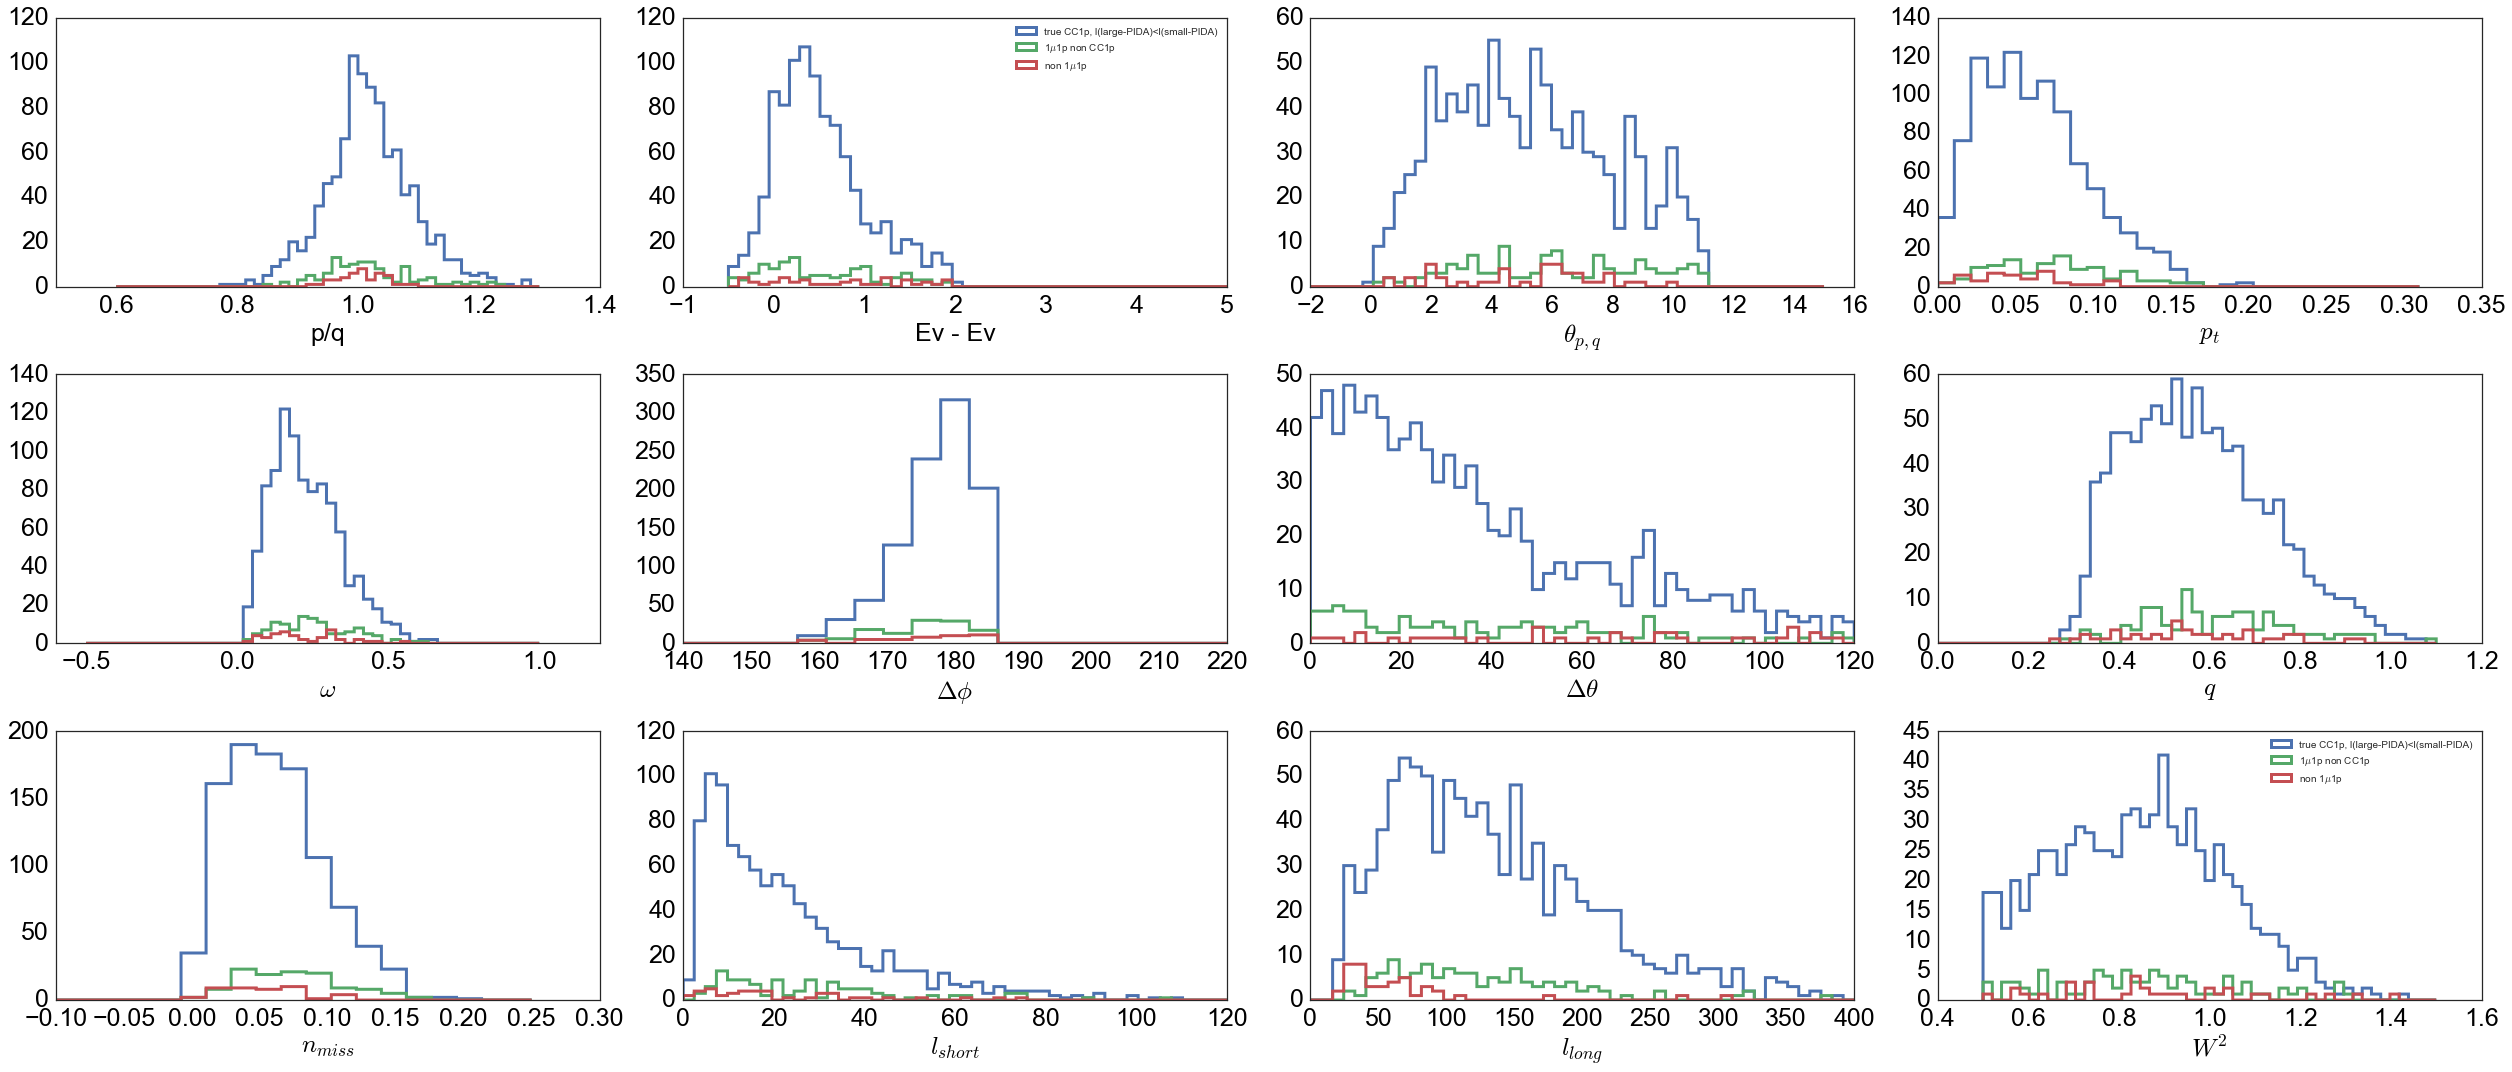

In [59]:
fig=plt.figure(figsize=(35,15))
ax =fig.add_subplot(3,4,1) 
bins=np.linspace(0.6,1.3,50)
plt.hist(reduced[1].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_p_over_q,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='p/q')

ax =fig.add_subplot(3,4,2) 
bins=np.linspace(-.5,5,50)
plt.hist(reduced[1].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_Ev_from_angles_Ev_from_mu_p_diff,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='Ev - Ev')
plt.legend()

ax =fig.add_subplot(3,4,3) 
bins=np.linspace(-2,15,50)
plt.hist(reduced[1].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_theta_pq,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\theta_{p,q}$')




ax =fig.add_subplot(3,4,4) 
bins=np.linspace(-0.,0.31,30)
plt.hist(reduced[1].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_Pt,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$p_t$')




ax =fig.add_subplot(3,4,5) 
bins=np.linspace(-0.5,1,50)
plt.hist(reduced[1].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_omega,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\omega$')



ax =fig.add_subplot(3,4,6) 
bins=np.linspace(140,220,20)
plt.hist(reduced[1].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].delta_phi,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\Delta \\phi$')



ax =fig.add_subplot(3,4,7) 
bins=np.linspace(0,120,50)
plt.hist(reduced[1].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].delta_theta,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$\\Delta \\theta$')



ax =fig.add_subplot(3,4,8) 
bins=np.linspace(0.,1.1,50)
plt.hist(reduced[1].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_q,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$q$')



ax =fig.add_subplot(3,4,9) 
bins=np.linspace(-0.1,0.25,20)
plt.hist(reduced[1].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_n_miss,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$n_{miss}$')


ax =fig.add_subplot(3,4,10) 
bins=np.linspace(0,120,50)
plt.hist(reduced[1].l_short,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].l_short,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].l_short,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$l_{short}$')



ax =fig.add_subplot(3,4,11) 
bins=np.linspace(0,400,50)
plt.hist(reduced[1].l_long,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].l_long,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].l_long,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$l_{long}$')



# ax =fig.add_subplot(3,4,12) 
# plt.hist([reduced[2].truth_Np,
#           reduced[2].truth_Nn,
#           reduced[2].truth_Npi,
#           reduced[2].truth_Nel,
#           reduced[2].truth_Ngamma],bins=np.linspace(0,4,5),label=['protons','neutrons','pions','electrons','photons']);


ax =fig.add_subplot(3,4,12 )
bins=np.linspace(0.5,1.5,50)
plt.hist(reduced[1].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[1]);
plt.hist(reduced[2].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[2]);
plt.hist(reduced[3].reco_CC1p_W2,histtype='step',bins=bins,linewidth=3,label=labels[3]);
set_axes(ax,x_label='$W^{2}$')
plt.legend()

plt.tight_layout()

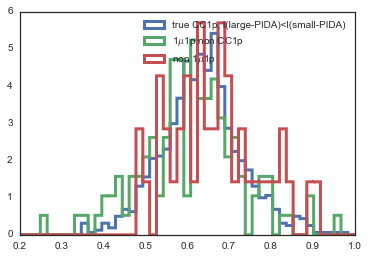

In [60]:
bins=np.linspace(0,50000,50)
# plt.hist(reduced[1].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[3]);


# plt.hist(reduced[1].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex_non_tracks_associated,histtype='step',bins=bins,linewidth=3,label=labels[3]);

# plt.hist(reduced[1].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[1]);
# plt.hist(reduced[2].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[2]);
# plt.hist(reduced[3].dqdx_around_vertex_tracks_associated,histtype='step',bins=np.linspace(0,50000,50),linewidth=3,label=labels[3]);


bins=np.linspace(0.2,1,50)
plt.hist(reduced[1].dqdx_around_vertex_tracks_associated/reduced[1].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[1],normed=1);
plt.hist(reduced[2].dqdx_around_vertex_tracks_associated/reduced[2].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[2],normed=1);
plt.hist(reduced[3].dqdx_around_vertex_tracks_associated/reduced[3].dqdx_around_vertex,histtype='step',bins=bins,linewidth=3,label=labels[3],normed=1);


plt.legend()

# manual scan 

In [97]:
#   y(max) ,
#   𝚫ɸ ,
#   𝜃(p,q) ,
#   p/q ,
#   cfdis , 
#   large-pida(min) ,
#   small-pida(max) ,
#   l-long(min) ,
#   l-short(max) , 
#   Pt(max),
#   Xb(min),
#   Xb-Pt(width)
#   W2-max ,
#   dq/dx around vertex non-tracks-associated (max) 
print_final_frac_in_samples([98,15,10,0.2,83,10,10,15,100,0.15,0.1,0.4,1.2,10000])
print 
# print_final_frac_in_samples([ 110. , 20. , 10. , 0.1 , 500 , 15. , 25 , 50 , 100 , 0.1 , 0.1 , 0.2 ])

MC-BNB true(GENIE) CC1p : 4.17%(42)
true CC1p, l(large-PIDA)<l(small-PIDA) : 5.07%(42)
1$\mu$1p non CC1p : 0.06%(1)
non 1$\mu$1p : 0.03%(12)
ext-BNB 2-tracks clusters : 0.00%(0)
open-cosmic MC : 0.00%(0)
MC-BNB true(GENIE) CC1p purity: 0.76
true CC1p, l(large-PIDA)<l(small-PIDA) purity: 0.76



NameError: name 'reduced_CC1p' is not defined

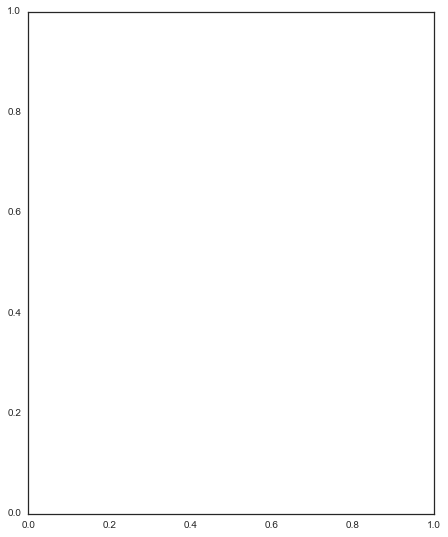

In [30]:
fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(1,2,1)
print len(reduced_CC1p)
plot_2d_hist(reduced_CC1p.truth_Ev ,reduced_CC1p.reco_CC1p_Ev , bins=np.linspace(0.2,1.5,50), xlabel='truth $E_{\\nu}$ [GeV/c]', ylabel='reco. $E_{\\nu}$ [GeV/c]',ax=ax);
ax.grid(linestyle='--',alpha=0.5)
ax=fig.add_subplot(1,2,2)
plt.hist(reduced_CC1p.truth_Ev - reduced_CC1p.reco_CC1p_Ev , bins=np.linspace(-1.,1.,50));
set_axes(ax, x_label='truth - reconstructed $E_{\\nu}$ [GeV/c]')
ax.grid(linestyle='--',alpha=0.5)
